# RUN PERFORMANCE PROJECT - Pau Sampietro

## Introductory application of unsupervised learning algorithms (Clustering records)

In this file, we try to understand better how the data is distributed along the main features: pace, vertical speed, heart-rate. The following analysis tries to be the starting point to cluster the records and be able to perform a **Grade adjusted pace (GAP)** conversion for the records.


As the goal is trying to give insights about how **cross-country training is different from flat runs (track)**, we apply some unsupervised machine learning algorithms: 
* K-Means cluestering
* DB-SCAN clustering

Once we extract the clusters with both methods, we compare the results with some metrics as silhouette score, and we try to improve the result changing some hyperparameters and  features selection.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import matplotlib.pyplot as plt
import cufflinks as cf 
from ipywidgets import interact
import plotly.graph_objs as go
from rpdb import read_table, read_table_sql, export_table

#### Importing data from tables stored in the DB

To work on this part, we only import the relevant and not redundant columns of the records table. (waiting time: ~ 1 min)

In [2]:
Ssql = """SELECT idmove, idrecord, enhanced_altitude, vertical_speed, records.heart_rate, records.pace, athlete
         FROM records INNER JOIN moves ON move = idmove
         WHERE athlete = 'P'"""

# Function created for this purpose, that imports data with specific select query 
records = read_table_sql('records', Ssql)

In [3]:
records.head()

,idmove,idrecord,enhanced_altitude,vertical_speed,heart_rate,pace,athlete
0,1,6,133.0,0.0,110.0,7.94,P
1,1,7,133.0,0.0,110.0,7.94,P
2,1,8,133.0,0.0,110.0,6.67,P
3,1,9,134.0,0.0,110.0,6.67,P
4,1,10,134.0,0.0,110.0,6.41,P


### 1. Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. heart rate compared to pace and vertical_speed). Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through **feature scaling**. We'll use this technique again with this dataset.

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()

# Subsampling to not running out of memory
records_feat = records[['enhanced_altitude', 'vertical_speed', 'heart_rate', 'pace']]
records_feat = records_feat.sample(100000)

records_sc = scaler.fit_transform(records_feat)

In [6]:
pd.DataFrame(records_sc).head()

,0,1,2,3
0,2.069901,0.290554,-1.357739,0.977858
1,-0.340122,0.353338,0.846464,0.141024
2,-0.539164,0.541693,0.019887,-0.440838
3,-0.349513,-1.027927,-0.531163,-0.319889
4,3.776155,-0.902358,-1.137319,2.112161


### 2. Data Clustering with K-Means algorithm

In [7]:
from sklearn.cluster import KMeans

In [8]:
# Instantiate the model and fit records features once they have been scaled
km_model = KMeans(n_clusters=4)
km_fit = km_model.fit(X=records_sc)

# We add a column with the labels provided by the algorithm
records_feat['kmeans_cluster'] = km_model.labels_

In [9]:
records_feat['kmeans_cluster'].value_counts()

0    49804
3    25877
1    14145
2    10174
Name: kmeans_cluster, dtype: int64

To begin applying the algorithm, we suppose we can separate data in 4 clusters. (it can be equivalent to flat endurance, speedy race, cross-country soft run, cross-country high power demand)), Also this 4 clusters could be mapped with run efficiency, as **the features are related with energy demand** (speed, vertical speed) and heart rate.

### 3. Data Clustering with DBSCAN algorithm

In [10]:
from sklearn.cluster import DBSCAN

In [11]:
# Instantiate the model and fit records features once they have been scaled
dbscan_model = DBSCAN(eps=0.5, min_samples=6)
dbscan_model.fit(records_sc)

# We add a column with the labels provided by the algorithm
records_feat['dbscan_cluster'] = dbscan_model.labels_

In [30]:
print(f"* number of clusters = {len(records_feat['dbscan_cluster'].value_counts())}")
records_feat['dbscan_cluster'].value_counts().head()

* number of clusters = 66


 0     95582
 2      1086
-1       860
 6       474
 16      473
Name: dbscan_cluster, dtype: int64

Applying DBSCAN with default parameters, we obtain too much clusters to analyze them. As the goal is classify the records in  few categories that could be related with GAP, this algorithm is not providing the best results.

### 4. Visualization of Clusters and performing some Metrics

#### 4.1. Metrics for raw clustering with both models

In [31]:
from sklearn.metrics import silhouette_score

In [32]:
km_sc = silhouette_score(records_feat, labels = km_model.labels_, metric='euclidean')

In [33]:
db_sc = silhouette_score(records_feat, labels = dbscan_model.labels_ , metric='euclidean')

In [34]:
print(f'Score for K-Means Clustering: Silouhette score = {km_sc}')
print(f'Score for DBSCAN Clustering: Silouhette score = {db_sc}')

Score for K-Means Clustering: Silouhette score = 0.013912097670498154
Score for DBSCAN Clustering: Silouhette score = -0.8050151815586316


As the best score is 1, and the worst is -1, we could apreciate that, for our data, K-Means algorithm performs a better clustering of the moves, having as a input this features:
* Scaled enhanced_altitude
* Scaled vertical_speed
* Scaled heart_rate
* Scaled pace

Anyway the score is not so good, so we would try to improve the model.

#### 4.2. Visualization in scatter plots of clusters done with both algorithms

In the cells below, we plot the results both in 2D Scatter plots with important features, and 3D plots with

##### * Vertical Speed vs. Heart Rate (2D). Cluster labels: K-MEANS

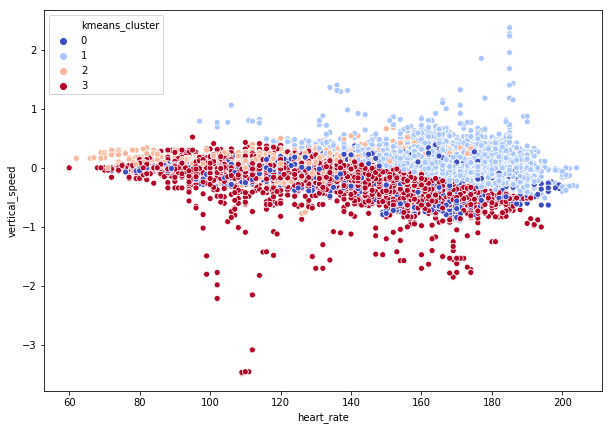

In [84]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='heart_rate',y='vertical_speed',data=records_feat ,hue='kmeans_cluster',palette="coolwarm")
plt.show()

##### * Vertical Speed vs. Heart Rate (2D). Cluster labels: DBSCAN 

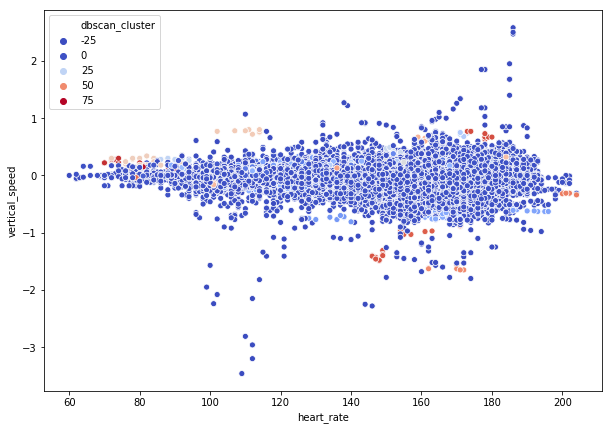

In [23]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='heart_rate',y='vertical_speed',data=records_feat ,hue='dbscan_cluster',palette="coolwarm")
plt.show()

##### * Pace vs. Vertical Speed vs. Heart Rate (3D). Cluster labels: K-MEANS

In [35]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


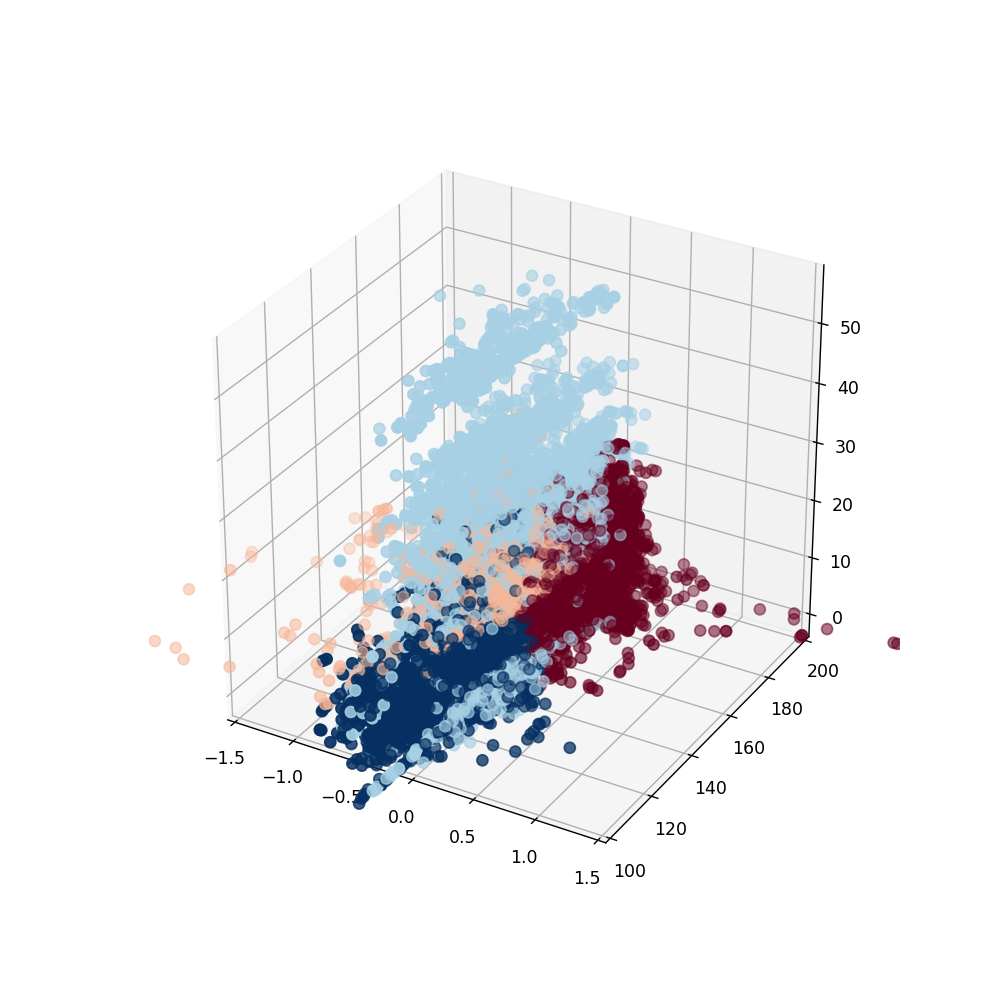

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
x = np.array(records_feat.pace)
y = np.array(records_feat.heart_rate)
z = np.array(records_feat.vertical_speed)

ax.scatter(z,y,x, marker="o", c=records_feat.kmeans_cluster, s=40, cmap="RdBu")
plt.xlim(-1.5,1.5)
plt.ylim(100,200)
plt.show()

##### * Vertical Speed vs. Heart Rate (2D). Cluster labels: DBSCAN

<IPython.core.display.Javascript object>


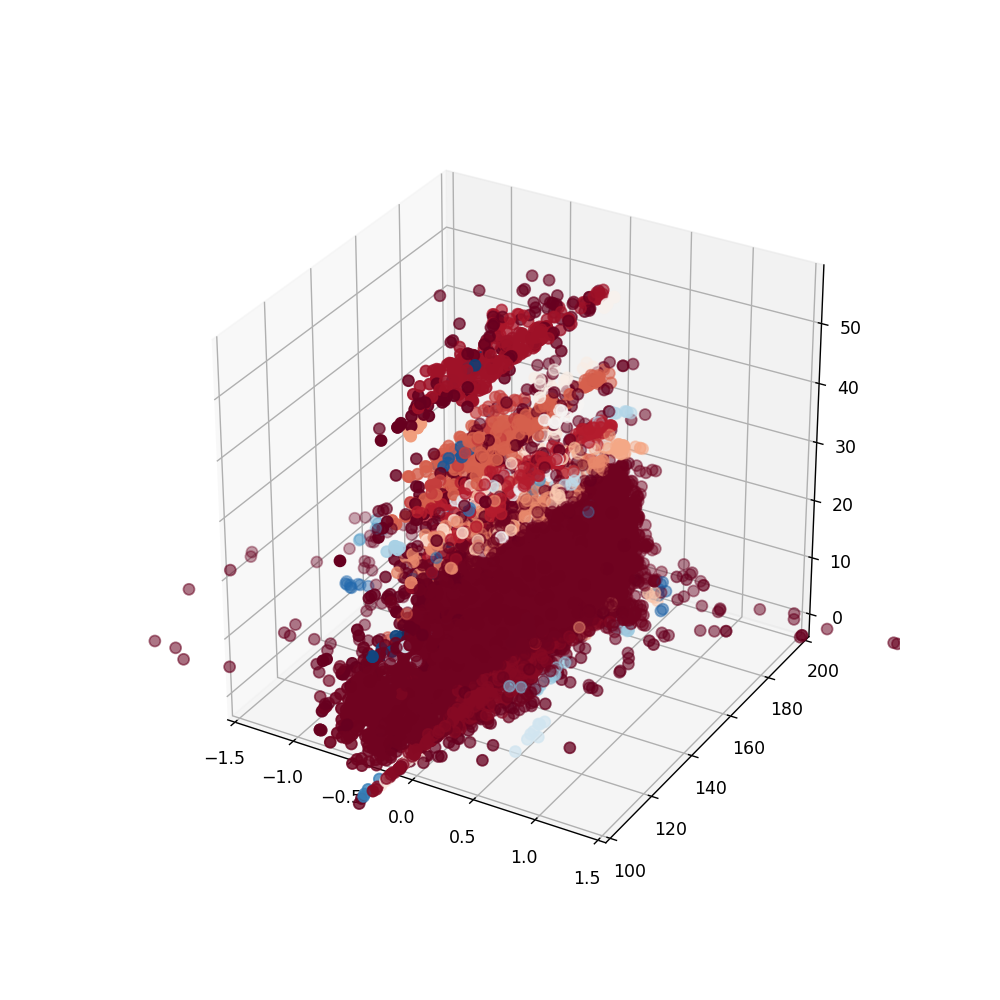

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
x = np.array(records_feat.pace)
y = np.array(records_feat.heart_rate)
z = np.array(records_feat.vertical_speed)

ax.scatter(z,y,x, marker="o", c=records_feat.dbscan_cluster, s=40, cmap="RdBu")
plt.xlim(-1.5,1.5)
plt.ylim(100,200)
plt.show()

### 5. Improvements in the model (using K-Means Algorithm)

In [ ]:
records_feat2 = records[['vertical_speed', 'heart_rate', 'pace']]
records_feat2 = records_feat2.sample(100000)

records_sc2 = scaler.fit_transform(records_feat2)